In [1]:
import gensim
gensim.__version__

'4.3.2'

In [2]:
!pip install konlpy

## 1. 영어 Word2Vec 만들기

In [3]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# 훈련데이터 다운로드 (ted talk script)
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7c5f5f24e890>)

In [6]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일에서 추출한 text로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 '문장' 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 '단어' 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [7]:
print('총 샘플(문장)의 개수 : {}'.format(len(result)))

총 샘플(문장)의 개수 : 273424


In [8]:
# 샘플(문장) 3개만 출력해서 토큰화된 단어 확인
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [9]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

- `vector_size` = 임베딩 된 벡터의 차원.
- `window` = 컨텍스트 윈도우 크기
- `min_count` = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- `workers` = 학습을 위한 프로세스 수
- `sg` = 0은 CBOW, 1은 Skip-gram.

CBOW는 target word 근처의 문맥을 파악하여 target word를 예측하는 방법이고, Skip-gram은 target word를 보고 문맥을 예측하는 방법입니다. `window`란 인자는 근처 문맥의 단어를 몇개로 할지 그 크기를 설정하는 인자입니다.

![neural language model vs word2vec](https://user-images.githubusercontent.com/115082062/213910013-2c91f210-090d-47f7-b842-33f64a3b2c50.png)


In [10]:
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

`model.wv.most_similar()`를 통해 입력한 단어와 가장 유사한 단어를 출력할 수 있습니다. 코사인 유사도를 기반으로 출력해줍니다.
원하는 단어를 input으로 넣어보세요!

In [11]:
model_result = model.wv.most_similar("ball")
print(model_result)

[('glass', 0.7870741486549377), ('rope', 0.7859057784080505), ('button', 0.7846086025238037), ('balloon', 0.7634117007255554), ('wheel', 0.7499558329582214), ('bag', 0.7479006052017212), ('wall', 0.7404651641845703), ('rock', 0.74029940366745), ('needle', 0.7375036478042603), ('sheet', 0.73199063539505)]


유사도를 기반으로 산정된 벡터들이기 때문에 연산도 가능합니다.

In [12]:
model.wv.most_similar(positive=['woman'], negative=['man'])

[('pregnant', 0.3822883069515228),
 ('autistic', 0.3525139093399048),
 ('child', 0.31199848651885986),
 ('male', 0.3095485270023346),
 ('cancer', 0.30328965187072754),
 ('trained', 0.30127763748168945),
 ('married', 0.29516685009002686),
 ('sex', 0.2901049554347992),
 ('treated', 0.2888518273830414),
 ('disease', 0.2879341244697571)]

In [13]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [14]:
model_result = loaded_model.most_similar("ball")
print(model_result)

[('glass', 0.7870741486549377), ('rope', 0.7859057784080505), ('button', 0.7846086025238037), ('balloon', 0.7634117007255554), ('wheel', 0.7499558329582214), ('bag', 0.7479006052017212), ('wall', 0.7404651641845703), ('rock', 0.74029940366745), ('needle', 0.7375036478042603), ('sheet', 0.73199063539505)]


## 2. 한국어 Word2Vec 만들기

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
import tqdm

### Okt 느릴 경우 Mecab 사용!
Okt 형태소 분석기가 느릴 경우 Mecab으로 하면 더 빠른 속도로 셀이 실행됩니다. 아래 방법대로 Mecab을 설치할 수 있습니다.

In [32]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh
from konlpy.tag import Mecab

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 5.45 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2024-07-10 08:23:32--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::22c2:513, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response-content

In [16]:
# 네이버 영화 리뷰 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7c5f293fd960>)

In [17]:
train_data = pd.read_table('ratings.txt')

In [18]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [19]:
print(len(train_data))

200000


In [20]:
train_data.info() # 결측값이 존재하는 행 8개 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [21]:
train_data = train_data.dropna(how = 'any') # 결측 값 존재하는 행 제거

In [22]:
print(len(train_data)) # 8개 행이 사라짐

199992


In [23]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [24]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [25]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# 불용어 리스트 정의
with open('/content/drive/MyDrive/data/stopword.txt') as f:
    list_file = f.readlines()
    stopwords = list_file[0].split(",")

okt를 사용할 경우 20분 내외의 런타임이 소요되지만, mecab을 사용할 경우 1분 내외의 런타임밖에 걸리지 않습니다.

따라서 시간 절약을 위해 mecab으로만 코드를 실행해보셔도 좋습니다.

In [ ]:
#using okt
#okt = Okt()

#tokenized_data = []
#for sentence in tqdm.tqdm(train_data['document']):
#    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
#   stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
#    tokenized_data.append(stopwords_removed_sentence)

In [50]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2024-07-10 08:38:30--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/g8l6dlu5a3ebovcdymluq/mecab-0.996-ko-0.9.2.tar.gz?rlkey=xlooryouhr1l2ufqbt93ohfvy&dl=1 [following]
--2024-07-10 08:38:30--  https://www.dropbox.com/scl/fi/g8l6dlu5a3ebovcdymluq/mecab-0.996-ko-0.9.2.tar.gz?rlkey=xlooryouhr1l2ufqbt93ohfvy&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce9c81191b390583d0a07b537df.dl.dropboxusercontent.com/cd/0/inline/CWZs14i_MnwW0dri0oDVE8TKEzfHFl_8nqH1SRdE4rqMONlWaWOPac89ViKItt4kz1kWt8RtRUUsKxKr45ZOwoJ6rD0GkJJY2grF260bqTHat4qWcpQQZBmDsHEBaSbaJ5SRjnv_py19Q7Ft2fVIYM3l/file?dl=1# [following]
--2024-07-10 08:38:31--  https://

In [27]:
!pip install mecab-python3

In [29]:
# using mecab
from konlpy.tag import Mecab
mecab = Mecab()

tokenized_data = []
for sentence in tqdm.tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [00:38<00:00, 5186.31it/s]


In [30]:
# 리뷰 3개의 토큰화 결과만 출력
print(tokenized_data[:3])

[['어릴', '때', '보', '고', '지금', '다시', '봐도', '재밌', '어요', 'ㅋㅋ'], ['디자인', '을', '배우', '는', '학생', '으로', ',', '외국', '디자이너', '와', '그', '들', '이', '일군', '전통', '을', '통해', '발전', '해', '가', '는', '문화', '산업', '이', '부러웠', '는데', '.', '사실', '우리', '나라', '에서', '도', '그', '어려운', '시절', '에', '끝', '까지', '열정', '을', '지킨', '노라노', '같', '은', '전통', '이', '있', '어', '저', '와', '같', '은', '사람', '들', '이', '꿈', '을', '꾸', '고', '이뤄나갈', '수', '있', '다는', '것', '에', '감사', '합니다', '.'], ['폴리스', '스토리', '시리즈', '는', '1', '부터', '뉴', '까지', '버릴', '께', '하나', '도', '없', '음', '.', '.', '최고', '.']]


리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 18.354304172166888


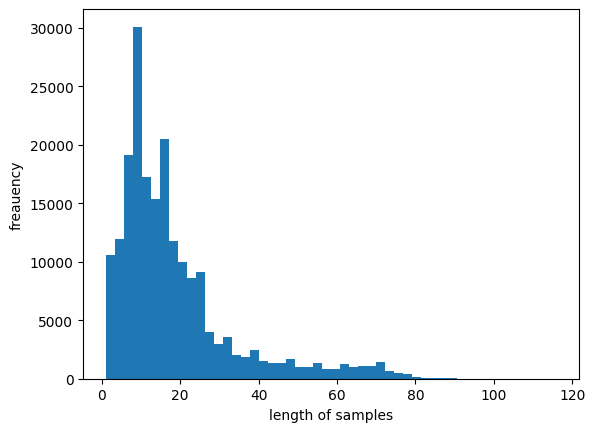

In [31]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('freauency')
plt.show()

In [32]:
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [33]:
model.wv.vectors.shape # 총 17806개의 단어가 100차원으로 구성되어있음.

(18960, 100)

In [34]:
print(model.wv.most_similar("이동진"))

[('대령', 0.7087836861610413), ('김혜리', 0.7027018666267395), ('****', 0.6825345158576965), ('추기경', 0.6821148991584778), ('황진미', 0.6806042194366455), ('김수환', 0.6711307764053345), ('도련', 0.668954074382782), ('양성', 0.6661275029182434), ('종형', 0.6499175429344177), ('시네', 0.648869514465332)]


In [35]:
model.wv.most_similar(positive=['타짜'])

[('REC', 0.8318782448768616),
 ('유어', 0.8220075964927673),
 ('전미', 0.8184505105018616),
 ('어벤져스', 0.8159516453742981),
 ('주유소', 0.8145359754562378),
 ('에이리언', 0.8112916350364685),
 ('리턴즈', 0.8106236457824707),
 ('록키', 0.8063871264457703),
 ('탕', 0.8059152960777283),
 ('논스톱', 0.8057680726051331)]

In [36]:
model.wv.most_similar(positive=['송강호'], negative=['주연'])

[('드라이브', 0.47830143570899963),
 ('마크', 0.4690777063369751),
 ('도끼', 0.46813157200813293),
 ('토나', 0.45641157031059265),
 ('도심', 0.44632723927497864),
 ('엘리엇', 0.445141464471817),
 ('김소은', 0.4448491930961609),
 ('일맥상통', 0.44422411918640137),
 ('장학우', 0.44146662950515747),
 ('렛', 0.441180020570755)]

In [37]:
model.wv.similarity('송강호', '하정우')

0.7985312

In [38]:
model.wv.similarity('송강호', '축구')

0.32730058